### Connect to Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Colab Notebooks/Challenge1/

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/Challenge1


### Import libraries

In [2]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)
from sklearn.preprocessing import LabelEncoder


2.14.0


In [4]:
# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input


# Load and split data

In [ ]:
# Conditional check for unzipping
unzip = True

# Unzip the 'public_data.npz' file if the 'unzip' flag is True
if unzip:
    !unzip changed_data.npz

# Unzip the 'public_data.npz' file if the 'unzip' flag is True
    !unzip changed_data.npz

Archive:  public_data.npz
replace data.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  public_data.npz
replace data.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [46]:
file1_data = np.load('data_del.npy',allow_pickle=True)
file2_labels = np.load('lab_del.npy',allow_pickle=True)
print(file1_data.shape)
print(file2_labels.shape, 'is in the wrong shape !')

(5004, 96, 96, 3)
(5004,) is in the wrong shape !


In [47]:
# use 0 and 1 for classes and adjust the labels in the format (row, 1)
label_encoder = LabelEncoder()
file2_labels = label_encoder.fit_transform(file2_labels)
print(file2_labels.shape)

file2_labels= file2_labels.reshape(-1, 1) # -1 is to use number of row of total element
print(file2_labels.shape)
print(file2_labels[:3])





(5004,)
(5004, 1)
[[0]
 [0]
 [0]]


In [48]:
labels={0:'healty', 1:'unhealty'}

In [49]:
#Normlaize images in [0,1]

#file1_data=(file1_data/255).astype('float32')
file1_data=(file1_data/255)

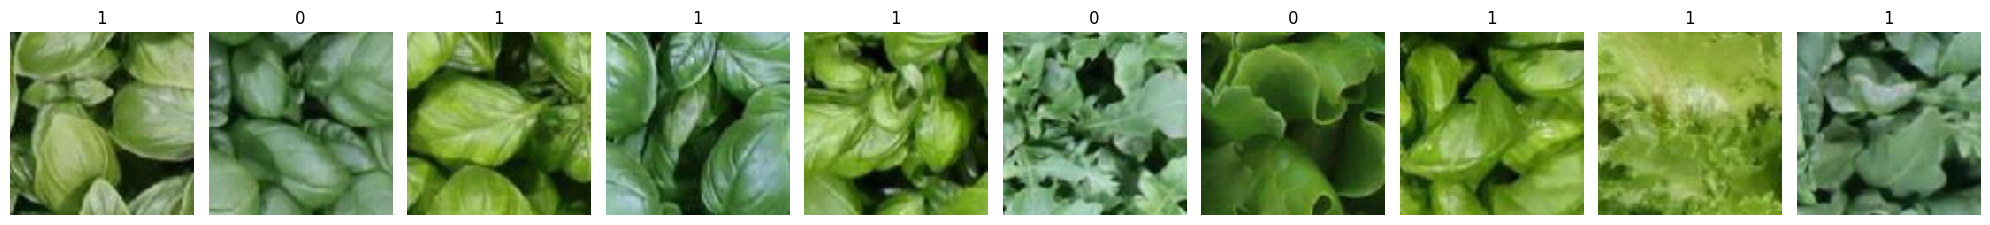

In [50]:
#visualization of 10 random images and their labels
num_img = 10
fig, axes = plt.subplots(1, num_img, figsize=(20, 9))

for i in range(num_img):
    index=random.randrange(0,len(file1_data)-1)
    ax = axes[i]
    ax.imshow(np.clip(file1_data[index], 0, 255))
    ax.set_title(file2_labels[index,0])
    ax.axis('off')

plt.tight_layout()
plt.show()


In [51]:
#Visualize the class distribution
dataframe=pd.DataFrame(file2_labels, columns=['class'])
print(dataframe['class'].value_counts())

0    3101
1    1903
Name: class, dtype: int64


In [52]:
#split the data in train_val e val
X_train_val, X_test, y_train_val, y_test = train_test_split(
    file1_data,
    file2_labels,
    test_size=0.1,      # 10%
    random_state=seed,
    stratify=dataframe
)

#further split into train and val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=len(X_test),  #test and validation set of same dimension
    random_state=seed,
    stratify=y_train_val
)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(4002, 96, 96, 3) (4002, 1)
(501, 96, 96, 3) (501, 1)
(501, 96, 96, 3) (501, 1)


In [53]:
#use to_categorical for one-hot encoding

y_train=tfk.utils.to_categorical(y_train)
y_val=tfk.utils.to_categorical(y_val)
y_test=tfk.utils.to_categorical(y_test)

print(y_train.shape)
print(y_train[:5])

(4002, 2)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [54]:
print(X_train.shape)
print(y_train.shape)

(4002, 96, 96, 3)
(4002, 2)


# MobileNetV2 (no Fine Tuning)

In [55]:
#key model parameters
input_shape=X_train_val.shape[1:] #(96, 96, 3)
output_shape=y_train.shape[1]     #2
batch_size=16
epochs=200

In [56]:
# Create MobileNetV2 model with specified settings
mobile = tfk.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg',
)

# Display the model architecture with input shapes
#tfk.utils.plot_model(mobile, show_shapes=True)

In [57]:
#lock the Feature extraction part
mobile.trainable=False

# Create an input layer with shape
inputs = tfk.Input(shape=(96, 96, 3))
# Connect MobileNetV2 to the input
x = mobile(inputs)
# Add a Dense layer with 2 units and softmax activation as the classifier
outputs = tfkl.Dense(2, activation='softmax')(x)

# Create a Model connecting input and output
model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Binary Cross-Entropy loss and Adam optimizer
model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 dense_4 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [58]:
# Train the model
history = model.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/200
251/251 [==============================] - 9s 19ms/step - loss: 0.5407 - accuracy: 0.7404 - val_loss: 0.4644 - val_accuracy: 0.8144
Epoch 2/200
251/251 [==============================] - 3s 11ms/step - loss: 0.4215 - accuracy: 0.8098 - val_loss: 0.4391 - val_accuracy: 0.8144
Epoch 3/200
251/251 [==============================] - 3s 11ms/step - loss: 0.3908 - accuracy: 0.8288 - val_loss: 0.4297 - val_accuracy: 0.8204
Epoch 4/200
251/251 [==============================] - 3s 13ms/step - loss: 0.3661 - accuracy: 0.8433 - val_loss: 0.4478 - val_accuracy: 0.7944
Epoch 5/200
251/251 [==============================] - 4s 16ms/step - loss: 0.3562 - accuracy: 0.8463 - val_loss: 0.4334 - val_accuracy: 0.7964
Epoch 6/200
251/251 [==============================] - 3s 12ms/step - loss: 0.3407 - accuracy: 0.8548 - val_loss: 0.4285 - val_accuracy: 0.8104
Epoch 7/200
251/251 [==============================] - 3s 11ms/step - loss: 0.3299 - accuracy: 0.8588 - val_loss: 0.4282 - val_accuracy:

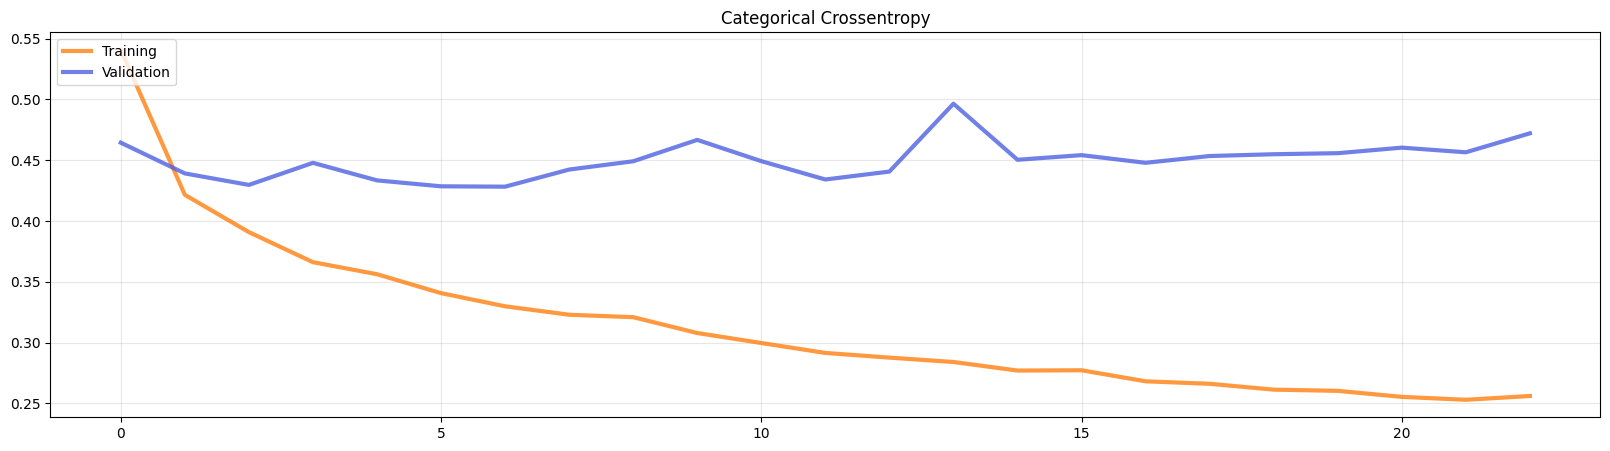

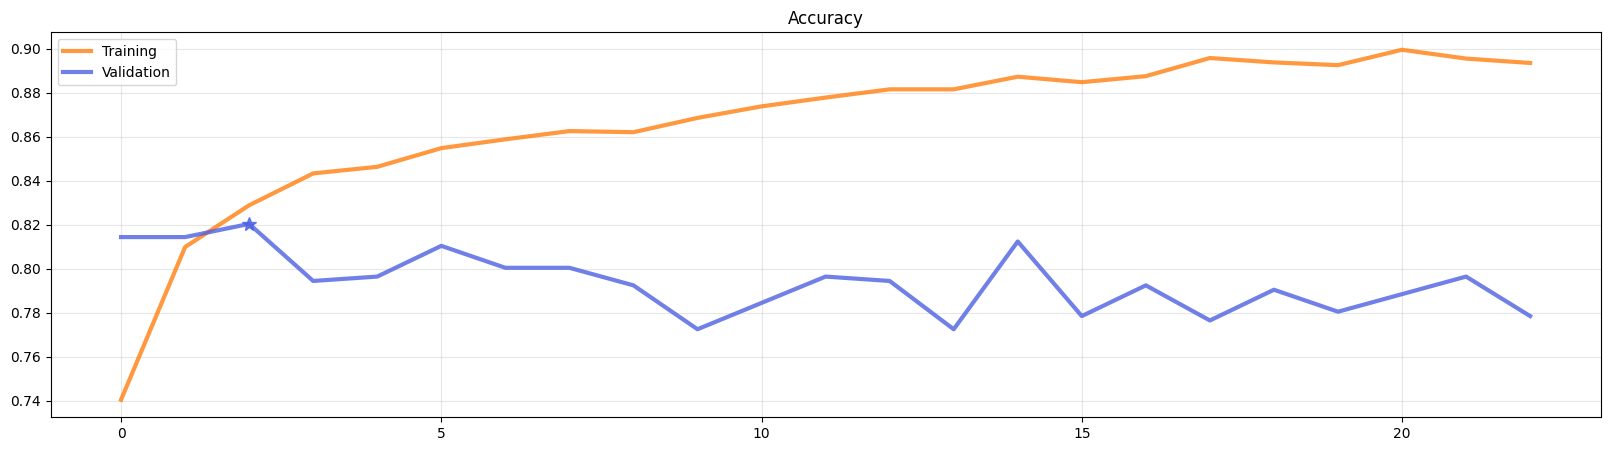

In [59]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [60]:
# Evaluate the model on the test set
test_accuracy = model.evaluate(preprocess_input(X_test*255),y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

Test set accuracy 0.8024


In [61]:
# Predict labels for the entire test set
predictions = model.predict(preprocess_input(X_test*255), verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)


Predictions Shape: (501, 2)


Accuracy: 0.8024
Precision: 0.8104
Recall: 0.765
F1: 0.7767


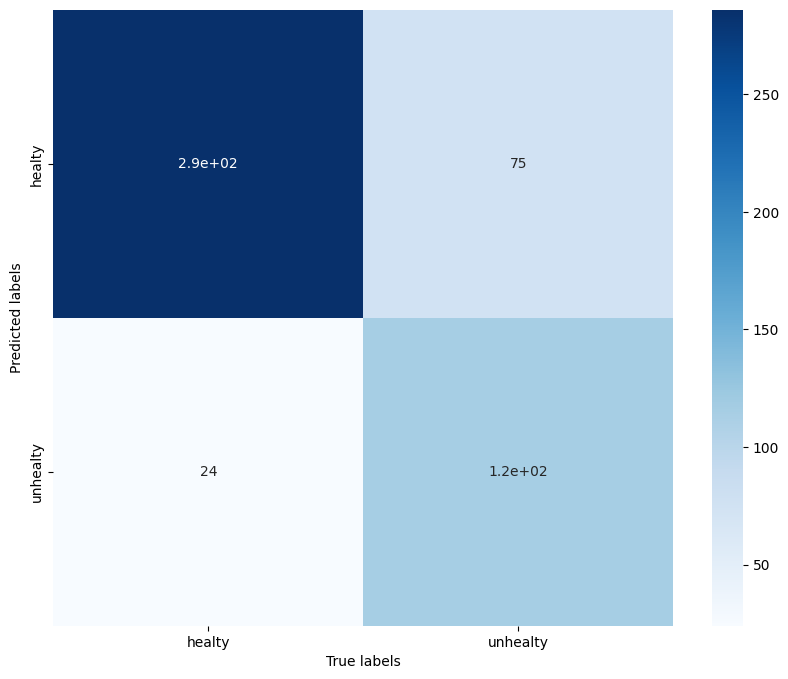

In [62]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

# Add Fine tuning (freeze up to layer 133)

In [63]:
#lock the Feature extraction part
mobile.trainable=False

# Create an input layer with shape
inputs = tfk.Input(shape=(96, 96, 3))
# Connect MobileNetV2 to the input
x = mobile(inputs)
# Add a Dense layer with 2 units and softmax activation as the classifier
outputs = tfkl.Dense(2, activation='softmax')(x)

# Create a Model connecting input and output
ft_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Binary Cross-Entropy loss and Adam optimizer
ft_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display model summary
ft_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 dense_5 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [64]:
# Set all MobileNetV2 layers as trainable (for now!)
ft_model.get_layer('mobilenetv2_1.00_96').trainable = True
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers):
   print(i, layer.name, layer.trainable)

0 input_7 True
1 Conv1 True
2 bn_Conv1 True
3 Conv1_relu True
4 expanded_conv_depthwise True
5 expanded_conv_depthwise_BN True
6 expanded_conv_depthwise_relu True
7 expanded_conv_project True
8 expanded_conv_project_BN True
9 block_1_expand True
10 block_1_expand_BN True
11 block_1_expand_relu True
12 block_1_pad True
13 block_1_depthwise True
14 block_1_depthwise_BN True
15 block_1_depthwise_relu True
16 block_1_project True
17 block_1_project_BN True
18 block_2_expand True
19 block_2_expand_BN True
20 block_2_expand_relu True
21 block_2_depthwise True
22 block_2_depthwise_BN True
23 block_2_depthwise_relu True
24 block_2_project True
25 block_2_project_BN True
26 block_2_add True
27 block_3_expand True
28 block_3_expand_BN True
29 block_3_expand_relu True
30 block_3_pad True
31 block_3_depthwise True
32 block_3_depthwise_BN True
33 block_3_depthwise_relu True
34 block_3_project True
35 block_3_project_BN True
36 block_4_expand True
37 block_4_expand_BN True
38 block_4_expand_relu Tru

In [65]:
# Freeze first N layers, e.g., until the 133rd one
N = 133
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_7 False
1 Conv1 False
2 bn_Conv1 False
3 Conv1_relu False
4 expanded_conv_depthwise False
5 expanded_conv_depthwise_BN False
6 expanded_conv_depthwise_relu False
7 expanded_conv_project False
8 expanded_conv_project_BN False
9 block_1_expand False
10 block_1_expand_BN False
11 block_1_expand_relu False
12 block_1_pad False
13 block_1_depthwise False
14 block_1_depthwise_BN False
15 block_1_depthwise_relu False
16 block_1_project False
17 block_1_project_BN False
18 block_2_expand False
19 block_2_expand_BN False
20 block_2_expand_relu False
21 block_2_depthwise False
22 block_2_depthwise_BN False
23 block_2_depthwise_relu False
24 block_2_project False
25 block_2_project_BN False
26 block_2_add False
27 block_3_expand False
28 block_3_expand_BN False
29 block_3_expand_relu False
30 block_3_pad False
31 block_3_depthwise False
32 block_3_depthwise_BN False
33 block_3_depthwise_relu False
34 block_3_project False
35 block_3_project_BN False
36 block_4_expand False
37 block_4_expa

In [66]:
# Fine-tune the model
history = ft_model.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/200
251/251 [==============================] - 9s 17ms/step - loss: 0.5309 - accuracy: 0.7494 - val_loss: 0.4663 - val_accuracy: 0.8044
Epoch 2/200
251/251 [==============================] - 3s 11ms/step - loss: 0.4199 - accuracy: 0.8148 - val_loss: 0.4396 - val_accuracy: 0.8044
Epoch 3/200
251/251 [==============================] - 3s 11ms/step - loss: 0.3897 - accuracy: 0.8293 - val_loss: 0.4313 - val_accuracy: 0.8244
Epoch 4/200
251/251 [==============================] - 3s 14ms/step - loss: 0.3651 - accuracy: 0.8421 - val_loss: 0.4533 - val_accuracy: 0.7944
Epoch 5/200
251/251 [==============================] - 4s 15ms/step - loss: 0.3543 - accuracy: 0.8456 - val_loss: 0.4343 - val_accuracy: 0.8204
Epoch 6/200
251/251 [==============================] - 3s 11ms/step - loss: 0.3402 - accuracy: 0.8551 - val_loss: 0.4284 - val_accuracy: 0.8164
Epoch 7/200
251/251 [==============================] - 3s 11ms/step - loss: 0.3285 - accuracy: 0.8598 - val_loss: 0.4304 - val_accuracy:

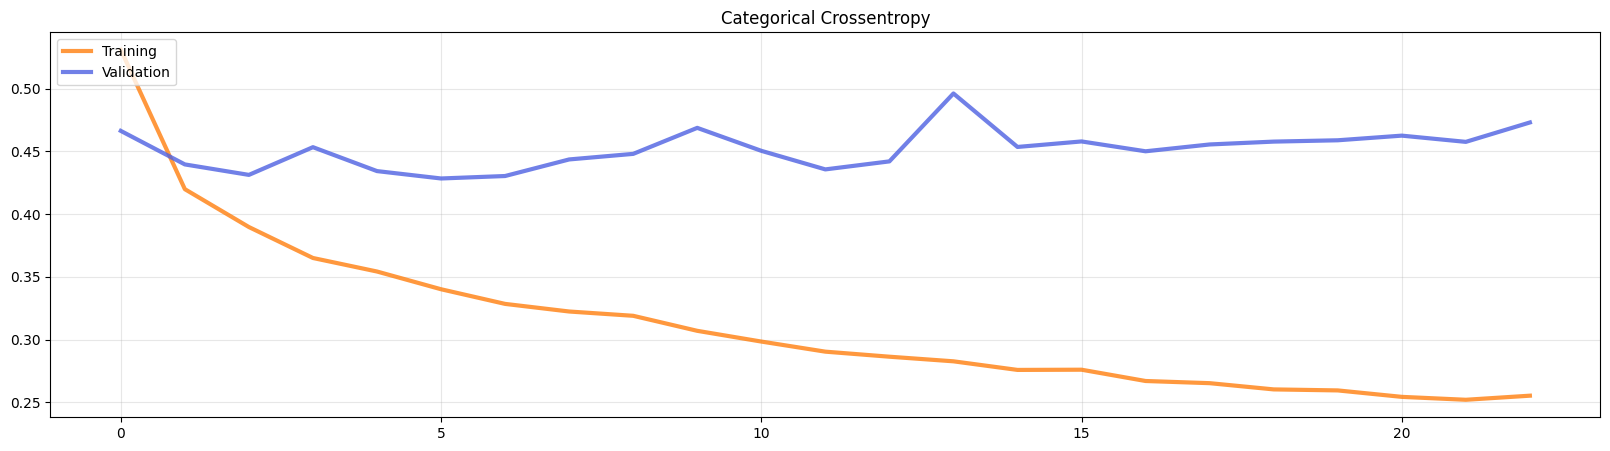

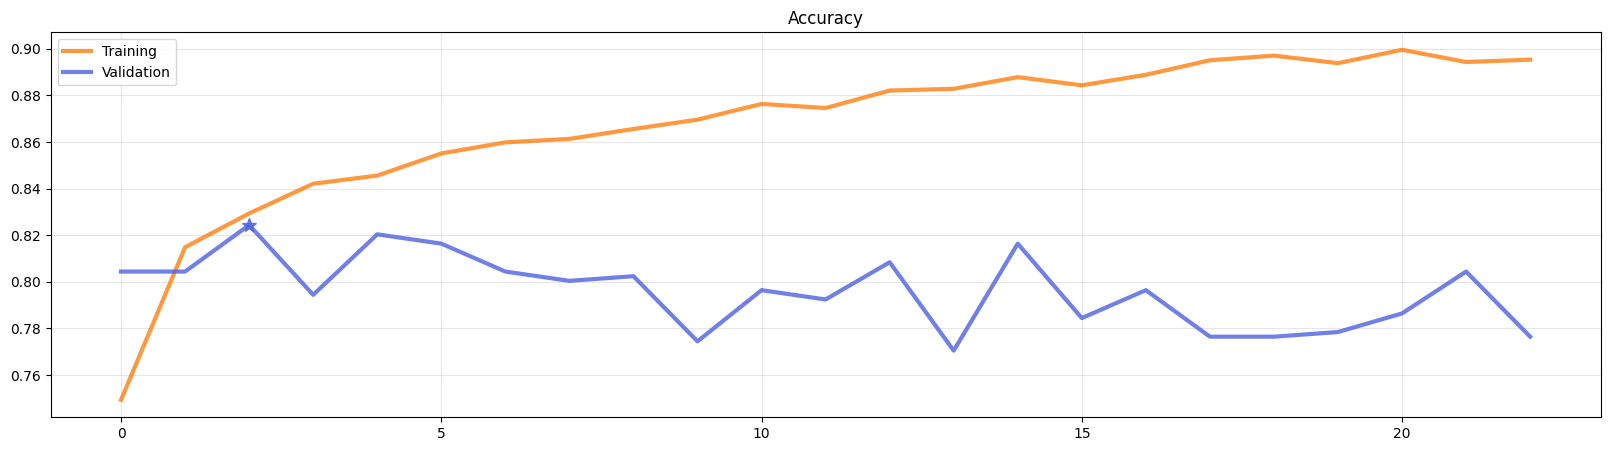

In [67]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [68]:
# Evaluate the model on the test set
test_accuracy = ft_model.evaluate(preprocess_input(X_test*255),y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

Test set accuracy 0.8044


In [69]:
# Predict labels for the entire test set
predictions = ft_model.predict(preprocess_input(X_test*255), verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)


Predictions Shape: (501, 2)


Accuracy: 0.8044
Precision: 0.8153
Recall: 0.7656
F1: 0.7779


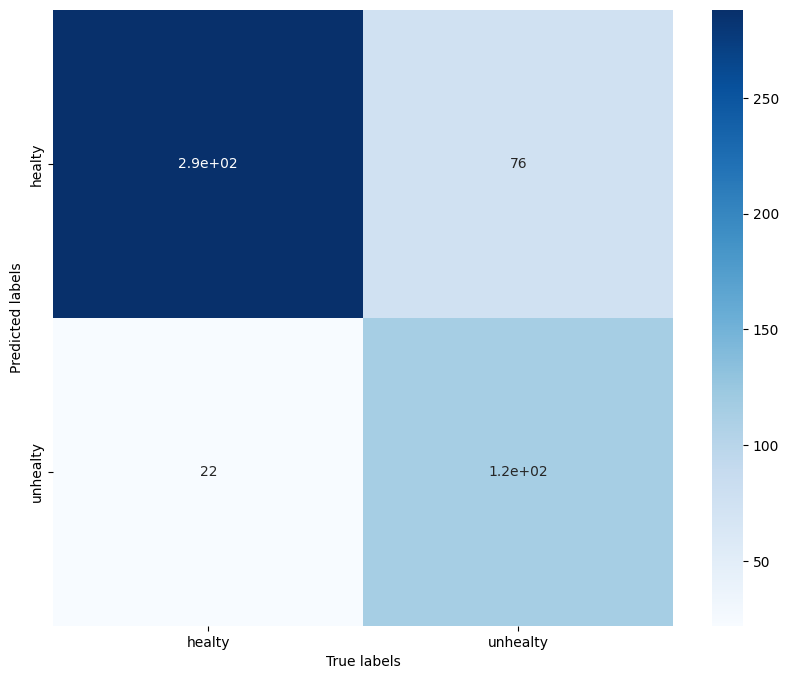

In [70]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
ft_model.save('MobileNet_saved')

# Freez up to layer 125

In [73]:
#lock the Feature extraction part
mobile.trainable=False

# Create an input layer with shape
inputs = tfk.Input(shape=(96, 96, 3))
# Connect MobileNetV2 to the input
x = mobile(inputs)
# Add a Dense layer with 2 units and softmax activation as the classifier
outputs = tfkl.Dense(2, activation='softmax')(x)

# Create a Model connecting input and output
ft_model_v2 = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Binary Cross-Entropy loss and Adam optimizer
ft_model_v2.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display model summary
ft_model_v2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 dense_7 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [74]:
# Set all MobileNetV2 layers as trainable (for now!)
ft_model_v2.get_layer('mobilenetv2_1.00_96').trainable = True
for i, layer in enumerate(ft_model_v2.get_layer('mobilenetv2_1.00_96').layers):
   print(i, layer.name, layer.trainable)

0 input_11 True
1 Conv1 True
2 bn_Conv1 True
3 Conv1_relu True
4 expanded_conv_depthwise True
5 expanded_conv_depthwise_BN True
6 expanded_conv_depthwise_relu True
7 expanded_conv_project True
8 expanded_conv_project_BN True
9 block_1_expand True
10 block_1_expand_BN True
11 block_1_expand_relu True
12 block_1_pad True
13 block_1_depthwise True
14 block_1_depthwise_BN True
15 block_1_depthwise_relu True
16 block_1_project True
17 block_1_project_BN True
18 block_2_expand True
19 block_2_expand_BN True
20 block_2_expand_relu True
21 block_2_depthwise True
22 block_2_depthwise_BN True
23 block_2_depthwise_relu True
24 block_2_project True
25 block_2_project_BN True
26 block_2_add True
27 block_3_expand True
28 block_3_expand_BN True
29 block_3_expand_relu True
30 block_3_pad True
31 block_3_depthwise True
32 block_3_depthwise_BN True
33 block_3_depthwise_relu True
34 block_3_project True
35 block_3_project_BN True
36 block_4_expand True
37 block_4_expand_BN True
38 block_4_expand_relu Tr

In [75]:
# Freeze first N layers, e.g., until the 125rd one
N = 125
for i, layer in enumerate(ft_model_v2.get_layer('mobilenetv2_1.00_96').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(ft_model_v2.get_layer('mobilenetv2_1.00_96').layers):
   print(i, layer.name, layer.trainable)
ft_model_v2.summary()

0 input_11 False
1 Conv1 False
2 bn_Conv1 False
3 Conv1_relu False
4 expanded_conv_depthwise False
5 expanded_conv_depthwise_BN False
6 expanded_conv_depthwise_relu False
7 expanded_conv_project False
8 expanded_conv_project_BN False
9 block_1_expand False
10 block_1_expand_BN False
11 block_1_expand_relu False
12 block_1_pad False
13 block_1_depthwise False
14 block_1_depthwise_BN False
15 block_1_depthwise_relu False
16 block_1_project False
17 block_1_project_BN False
18 block_2_expand False
19 block_2_expand_BN False
20 block_2_expand_relu False
21 block_2_depthwise False
22 block_2_depthwise_BN False
23 block_2_depthwise_relu False
24 block_2_project False
25 block_2_project_BN False
26 block_2_add False
27 block_3_expand False
28 block_3_expand_BN False
29 block_3_expand_relu False
30 block_3_pad False
31 block_3_depthwise False
32 block_3_depthwise_BN False
33 block_3_depthwise_relu False
34 block_3_project False
35 block_3_project_BN False
36 block_4_expand False
37 block_4_exp

In [76]:
# Fine-tune the model
history = ft_model_v2.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/200
251/251 [==============================] - 7s 16ms/step - loss: 0.5310 - accuracy: 0.7399 - val_loss: 0.4538 - val_accuracy: 0.8084
Epoch 2/200
251/251 [==============================] - 3s 11ms/step - loss: 0.4172 - accuracy: 0.8193 - val_loss: 0.4342 - val_accuracy: 0.8184
Epoch 3/200
251/251 [==============================] - 4s 14ms/step - loss: 0.3873 - accuracy: 0.8336 - val_loss: 0.4285 - val_accuracy: 0.8283
Epoch 4/200
251/251 [==============================] - 4s 16ms/step - loss: 0.3631 - accuracy: 0.8433 - val_loss: 0.4447 - val_accuracy: 0.7904
Epoch 5/200
251/251 [==============================] - 3s 11ms/step - loss: 0.3532 - accuracy: 0.8466 - val_loss: 0.4340 - val_accuracy: 0.8044
Epoch 6/200
251/251 [==============================] - 3s 11ms/step - loss: 0.3388 - accuracy: 0.8548 - val_loss: 0.4295 - val_accuracy: 0.8104
Epoch 7/200
251/251 [==============================] - 3s 11ms/step - loss: 0.3280 - accuracy: 0.8591 - val_loss: 0.4304 - val_accuracy:

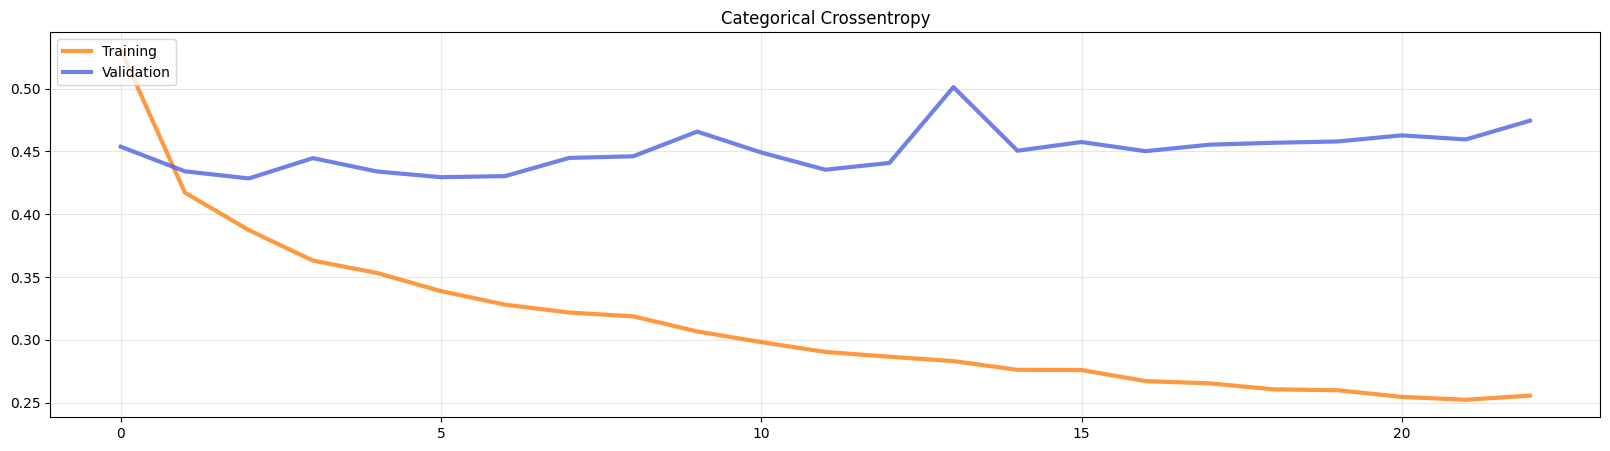

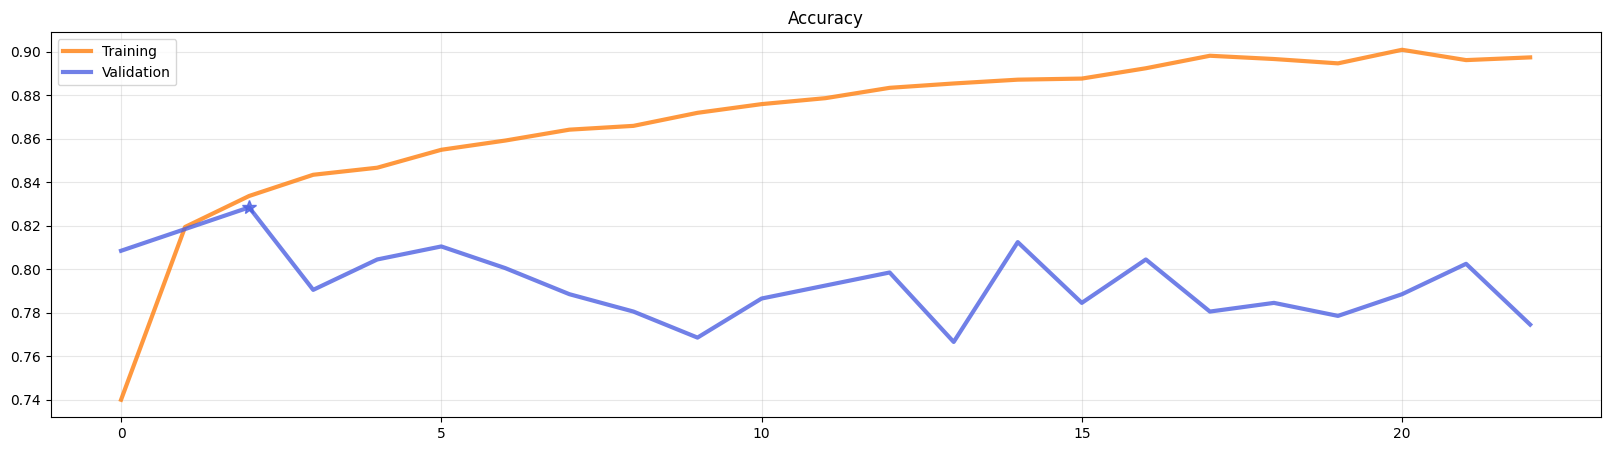

In [77]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [78]:
# Evaluate the model on the test set
test_accuracy = ft_model.evaluate(preprocess_input(X_test*255),y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

Test set accuracy 0.8044


In [79]:
# Predict labels for the entire test set
predictions = ft_model.predict(preprocess_input(X_test*255), verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)


Predictions Shape: (501, 2)


Accuracy: 0.8044
Precision: 0.8153
Recall: 0.7656
F1: 0.7779


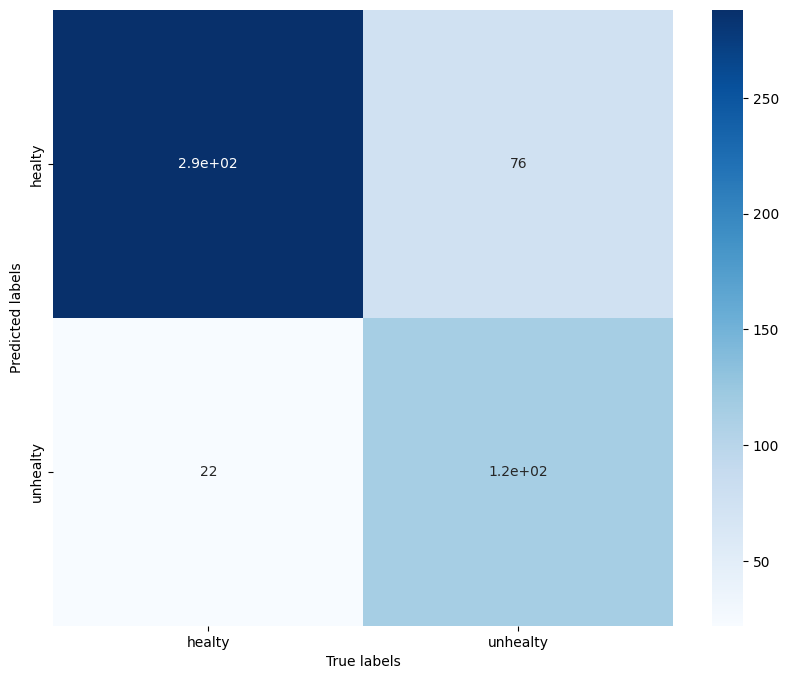

In [80]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

# Add Dropout, l2 regularizer, AdamW

In [81]:
#lock the Feature extraction part
mobile.trainable=False

# Create an input layer with shape
inputs = tfk.Input(shape=(96, 96, 3))

# Connect MobileNetV2 to the input
x = mobile(inputs)

# WE TESTED VARIOUS VALUES FOR THE DROP OUT RATE (FROM 0.17% TO .035%)
x = tfkl.Dropout(0.3, name='dropout0')(x)  # The drop out layer

# Add a Dense layer with 2 units and softmax activation as the classifier
# WE HAVE TRIED VARIOUS l2 VALUES
outputs = tfkl.Dense(2, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(1e-3))(x)


# Create a Model connecting input and output
ft_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Binary Cross-Entropy loss and Adam optimizer
# WE TESTED VARIOUS VALUES FOR LEARNING RATE(from e-3 to e-4) AND WEIGHT DECAY(values around 5*e-4)
ft_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.AdamW(learning_rate=1e-4, weight_decay=5e-4), metrics=['accuracy'])


# Display model summary
ft_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 dropout0 (Dropout)          (None, 1280)              0         
                                                                 
 dense_8 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [82]:
# Set all MobileNetV2 layers as trainable (for now!)
ft_model.get_layer('mobilenetv2_1.00_96').trainable = True
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers):
   print(i, layer.name, layer.trainable)

0 input_11 True
1 Conv1 True
2 bn_Conv1 True
3 Conv1_relu True
4 expanded_conv_depthwise True
5 expanded_conv_depthwise_BN True
6 expanded_conv_depthwise_relu True
7 expanded_conv_project True
8 expanded_conv_project_BN True
9 block_1_expand True
10 block_1_expand_BN True
11 block_1_expand_relu True
12 block_1_pad True
13 block_1_depthwise True
14 block_1_depthwise_BN True
15 block_1_depthwise_relu True
16 block_1_project True
17 block_1_project_BN True
18 block_2_expand True
19 block_2_expand_BN True
20 block_2_expand_relu True
21 block_2_depthwise True
22 block_2_depthwise_BN True
23 block_2_depthwise_relu True
24 block_2_project True
25 block_2_project_BN True
26 block_2_add True
27 block_3_expand True
28 block_3_expand_BN True
29 block_3_expand_relu True
30 block_3_pad True
31 block_3_depthwise True
32 block_3_depthwise_BN True
33 block_3_depthwise_relu True
34 block_3_project True
35 block_3_project_BN True
36 block_4_expand True
37 block_4_expand_BN True
38 block_4_expand_relu Tr

In [83]:
# Freeze first N layers, e.g., until the 125rd one
N = 125
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_11 False
1 Conv1 False
2 bn_Conv1 False
3 Conv1_relu False
4 expanded_conv_depthwise False
5 expanded_conv_depthwise_BN False
6 expanded_conv_depthwise_relu False
7 expanded_conv_project False
8 expanded_conv_project_BN False
9 block_1_expand False
10 block_1_expand_BN False
11 block_1_expand_relu False
12 block_1_pad False
13 block_1_depthwise False
14 block_1_depthwise_BN False
15 block_1_depthwise_relu False
16 block_1_project False
17 block_1_project_BN False
18 block_2_expand False
19 block_2_expand_BN False
20 block_2_expand_relu False
21 block_2_depthwise False
22 block_2_depthwise_BN False
23 block_2_depthwise_relu False
24 block_2_project False
25 block_2_project_BN False
26 block_2_add False
27 block_3_expand False
28 block_3_expand_BN False
29 block_3_expand_relu False
30 block_3_pad False
31 block_3_depthwise False
32 block_3_depthwise_BN False
33 block_3_depthwise_relu False
34 block_3_project False
35 block_3_project_BN False
36 block_4_expand False
37 block_4_exp

In [84]:

# Fine-tune the model
history = ft_model.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/200
251/251 [==============================] - 8s 19ms/step - loss: 0.8566 - accuracy: 0.5232 - val_loss: 0.6856 - val_accuracy: 0.6108
Epoch 2/200
251/251 [==============================] - 4s 17ms/step - loss: 0.7237 - accuracy: 0.6254 - val_loss: 0.6148 - val_accuracy: 0.6986
Epoch 3/200
251/251 [==============================] - 3s 12ms/step - loss: 0.6570 - accuracy: 0.6739 - val_loss: 0.5734 - val_accuracy: 0.7246
Epoch 4/200
251/251 [==============================] - 3s 11ms/step - loss: 0.6165 - accuracy: 0.7061 - val_loss: 0.5450 - val_accuracy: 0.7665
Epoch 5/200
251/251 [==============================] - 3s 11ms/step - loss: 0.5816 - accuracy: 0.7324 - val_loss: 0.5231 - val_accuracy: 0.7824
Epoch 6/200
251/251 [==============================] - 3s 14ms/step - loss: 0.5605 - accuracy: 0.7389 - val_loss: 0.5074 - val_accuracy: 0.7864
Epoch 7/200
251/251 [==============================] - 4s 17ms/step - loss: 0.5374 - accuracy: 0.7621 - val_loss: 0.4963 - val_accuracy:

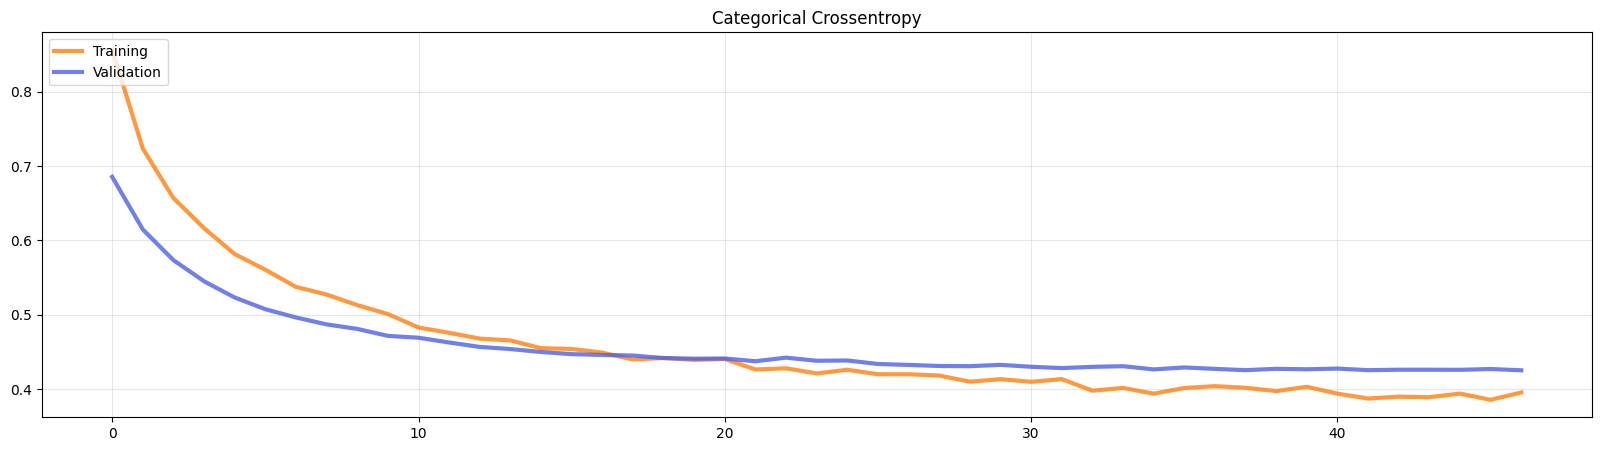

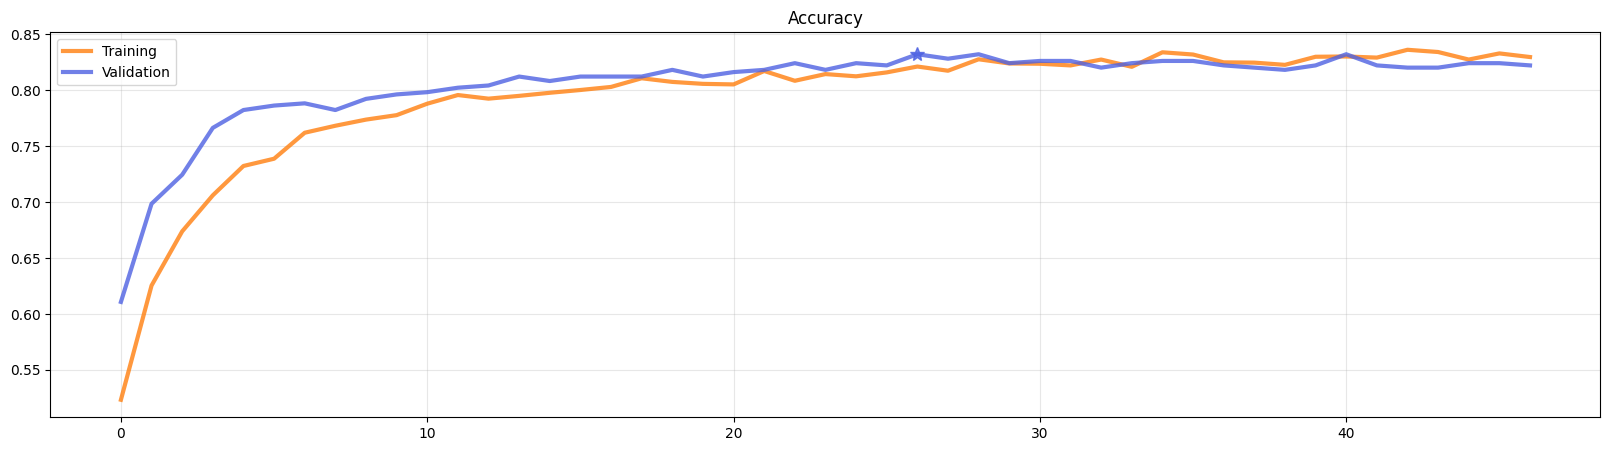

In [85]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [86]:
# Evaluate the model on the test set
test_accuracy = ft_model.evaluate(preprocess_input(X_test*255),y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

Test set accuracy 0.8044


In [87]:
# Predict labels for the entire test set
predictions = ft_model.predict(preprocess_input(X_test*255), verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)


Predictions Shape: (501, 2)


Accuracy: 0.8044
Precision: 0.8003
Recall: 0.7776
F1: 0.7854


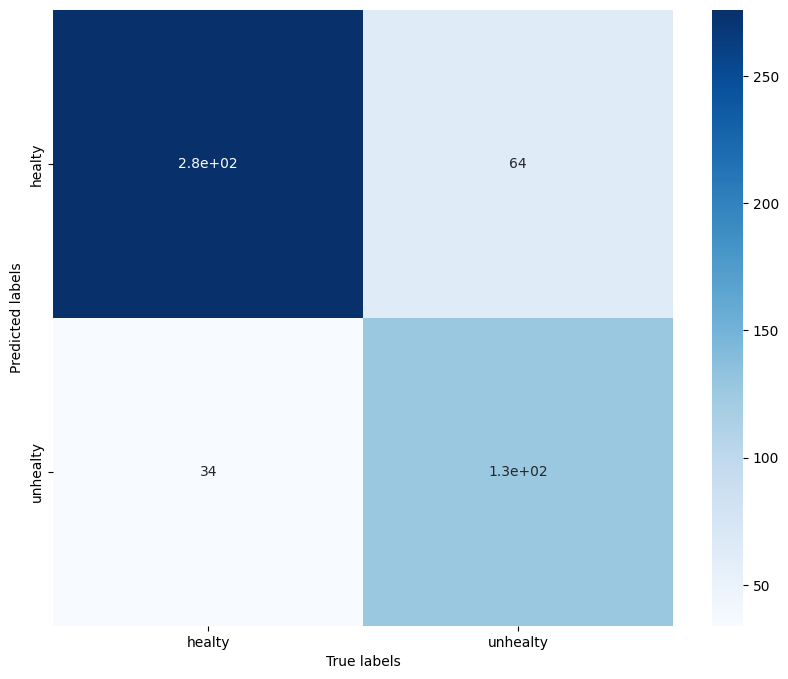

In [88]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
ft_model.save('MobileNet_saved')

In [ ]:
#del ft_model
#ft_model=tfk.models.load_model("MobileNet_saved")

# Add Augmentation


In [89]:
#lock the Feature extraction part
mobile.trainable=False

#I TRY TO USE THE TRANSFORMATIONS THAT SEEM MOST APPROPRIATE
preprocessing = tf.keras.Sequential([
        tfkl.RandomFlip("horizontal"),
        tfkl.RandomTranslation(0.2,0.2),
        tfkl.RandomRotation(0.2),
    ], name='preprocessing')

# Create an input layer with shape
inputs = tfk.Input(shape=(96, 96, 3))

preprocessing = preprocessing(inputs)


# Connect MobileNetV2 to the input
x = mobile(preprocessing)

x = tfkl.Dropout(0.3, name='dropout0')(x)  # Drop out layer

# Add a Dense layer with 2 units and softmax activation as the classifier
outputs = tfkl.Dense(2, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(1e-3))(x)

# Create a Model connecting input and output
ft_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Binary Cross-Entropy loss and Adam optimizer
ft_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.AdamW(learning_rate=1e-4, weight_decay=5e-4), metrics=['accuracy'])


# Display model summary
ft_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 dropout0 (Dropout)          (None, 1280)              0         
                                                                 
 dense_9 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_____________________

In [90]:
# Set all MobileNetV2 layers as trainable (for now!)
ft_model.get_layer('mobilenetv2_1.00_96').trainable = True
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers):
   print(i, layer.name, layer.trainable)

0 input_11 True
1 Conv1 True
2 bn_Conv1 True
3 Conv1_relu True
4 expanded_conv_depthwise True
5 expanded_conv_depthwise_BN True
6 expanded_conv_depthwise_relu True
7 expanded_conv_project True
8 expanded_conv_project_BN True
9 block_1_expand True
10 block_1_expand_BN True
11 block_1_expand_relu True
12 block_1_pad True
13 block_1_depthwise True
14 block_1_depthwise_BN True
15 block_1_depthwise_relu True
16 block_1_project True
17 block_1_project_BN True
18 block_2_expand True
19 block_2_expand_BN True
20 block_2_expand_relu True
21 block_2_depthwise True
22 block_2_depthwise_BN True
23 block_2_depthwise_relu True
24 block_2_project True
25 block_2_project_BN True
26 block_2_add True
27 block_3_expand True
28 block_3_expand_BN True
29 block_3_expand_relu True
30 block_3_pad True
31 block_3_depthwise True
32 block_3_depthwise_BN True
33 block_3_depthwise_relu True
34 block_3_project True
35 block_3_project_BN True
36 block_4_expand True
37 block_4_expand_BN True
38 block_4_expand_relu Tr

In [91]:
# Freeze first N layers, e.g., until the 125rd one
N = 125
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_11 False
1 Conv1 False
2 bn_Conv1 False
3 Conv1_relu False
4 expanded_conv_depthwise False
5 expanded_conv_depthwise_BN False
6 expanded_conv_depthwise_relu False
7 expanded_conv_project False
8 expanded_conv_project_BN False
9 block_1_expand False
10 block_1_expand_BN False
11 block_1_expand_relu False
12 block_1_pad False
13 block_1_depthwise False
14 block_1_depthwise_BN False
15 block_1_depthwise_relu False
16 block_1_project False
17 block_1_project_BN False
18 block_2_expand False
19 block_2_expand_BN False
20 block_2_expand_relu False
21 block_2_depthwise False
22 block_2_depthwise_BN False
23 block_2_depthwise_relu False
24 block_2_project False
25 block_2_project_BN False
26 block_2_add False
27 block_3_expand False
28 block_3_expand_BN False
29 block_3_expand_relu False
30 block_3_pad False
31 block_3_depthwise False
32 block_3_depthwise_BN False
33 block_3_depthwise_relu False
34 block_3_project False
35 block_3_project_BN False
36 block_4_expand False
37 block_4_exp

In [92]:

# Fine-tune the model
history = ft_model.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/200
251/251 [==============================] - 10s 22ms/step - loss: 0.8056 - accuracy: 0.5727 - val_loss: 0.6884 - val_accuracy: 0.6447
Epoch 2/200
251/251 [==============================] - 3s 14ms/step - loss: 0.7277 - accuracy: 0.6379 - val_loss: 0.6303 - val_accuracy: 0.7006
Epoch 3/200
251/251 [==============================] - 4s 14ms/step - loss: 0.6739 - accuracy: 0.6529 - val_loss: 0.5970 - val_accuracy: 0.7126
Epoch 4/200
251/251 [==============================] - 5s 20ms/step - loss: 0.6358 - accuracy: 0.6914 - val_loss: 0.5679 - val_accuracy: 0.7605
Epoch 5/200
251/251 [==============================] - 4s 15ms/step - loss: 0.6112 - accuracy: 0.7056 - val_loss: 0.5520 - val_accuracy: 0.7665
Epoch 6/200
251/251 [==============================] - 3s 13ms/step - loss: 0.6193 - accuracy: 0.7034 - val_loss: 0.5361 - val_accuracy: 0.7665
Epoch 7/200
251/251 [==============================] - 3s 13ms/step - loss: 0.5764 - accuracy: 0.7391 - val_loss: 0.5229 - val_accuracy

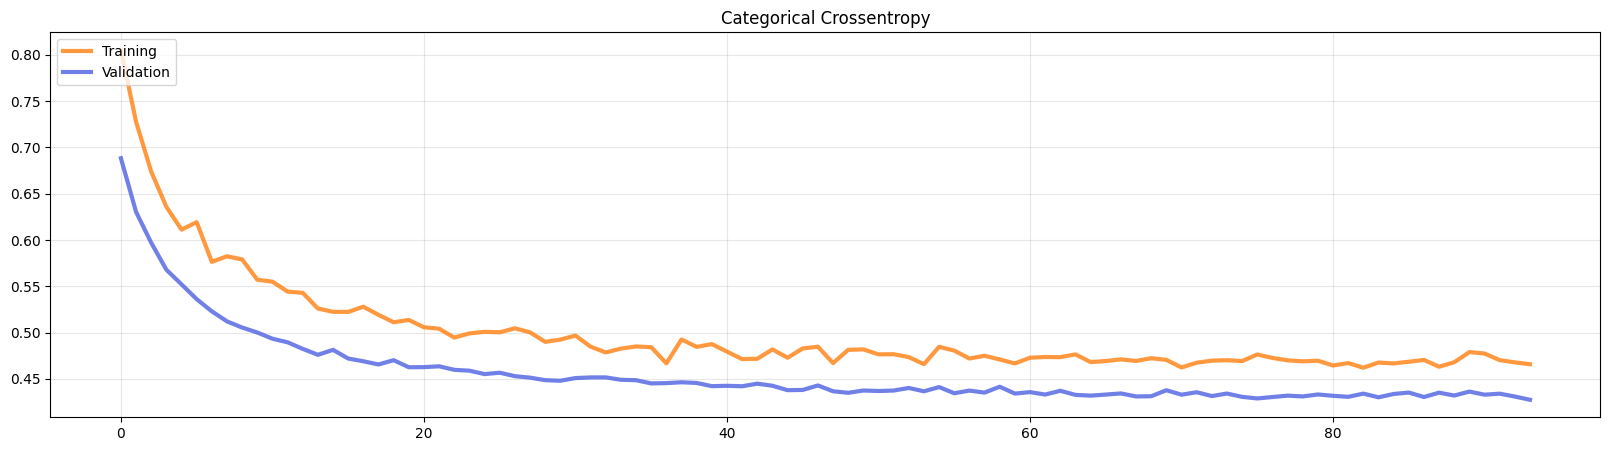

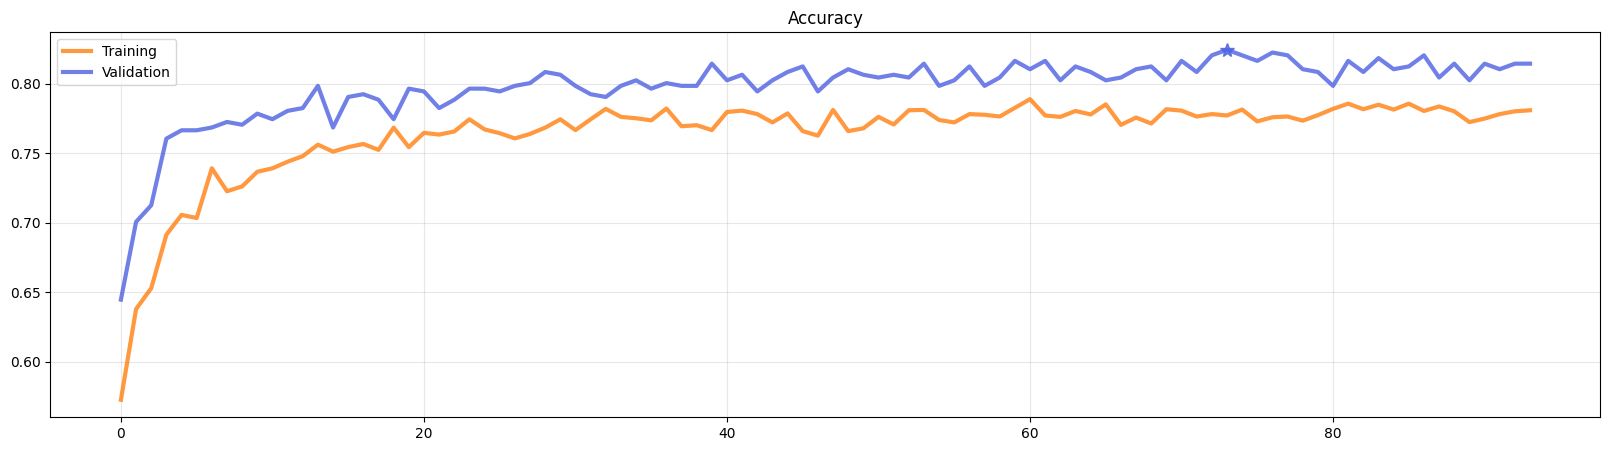

In [93]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [94]:
# Evaluate the model on the test set
test_accuracy = ft_model.evaluate(preprocess_input(X_test*255),y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

Test set accuracy 0.7745


In [95]:
# Predict labels for the entire test set
predictions = ft_model.predict(preprocess_input(X_test*255), verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)


Predictions Shape: (501, 2)


Accuracy: 0.7745
Precision: 0.7797
Recall: 0.7323
F1: 0.7427


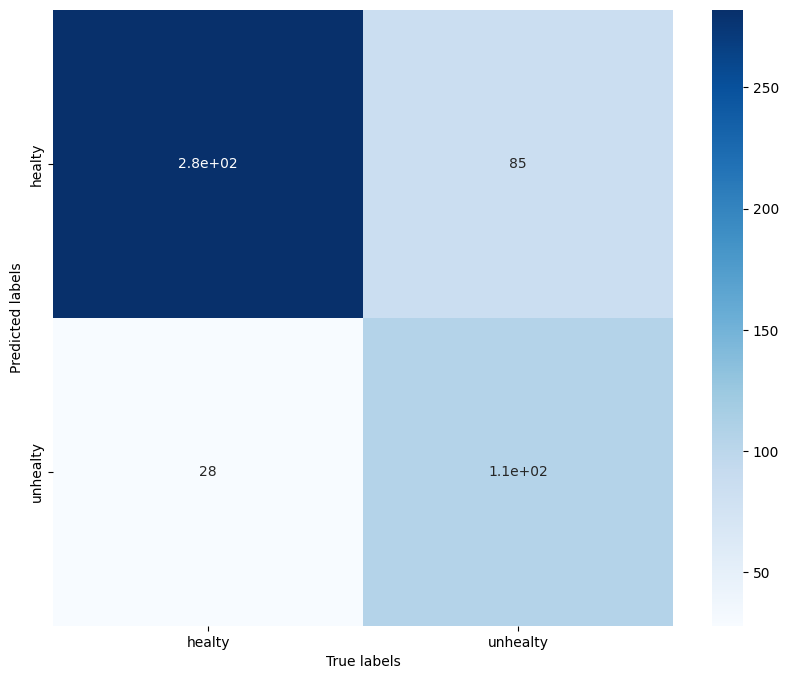

In [96]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
ft_model.save('MobileNet_saved')

# With Sigmoid as output fx


In [ ]:
# I have to reload the data because I don't have to use to_categorical for labels

In [97]:
file1_data = np.load('data_del.npy',allow_pickle=True)
file2_labels = np.load('lab_del.npy',allow_pickle=True)
print(file1_data.shape)
print(file2_labels.shape, 'is in the wrong shape !')

(5004, 96, 96, 3)
(5004,) is in the wrong shape !


In [98]:
# use 0 and 1 for classes and adjust the labels in the format (row, 1)
label_encoder = LabelEncoder()
file2_labels = label_encoder.fit_transform(file2_labels)
print(file2_labels.shape)

file2_labels= file2_labels.reshape(-1, 1) # -1 is to use number of row of total element
print(file2_labels.shape)
print(file2_labels[:3])

(5004,)
(5004, 1)
[[0]
 [0]
 [0]]


In [99]:
labels={0:'healty', 1:'unhealty'}

In [100]:
#Normlaize images in [0,1]
file1_data=(file1_data/255)

In [101]:
#split the data in train_val e val
X_train_val, X_test, y_train_val, y_test = train_test_split(
    file1_data,
    file2_labels,
    test_size=0.1,      # 10%
    random_state=seed,
    stratify=dataframe
)

#further split into train and val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=len(X_test),  #test and validation set of same dimension
    random_state=seed,
    stratify=y_train_val
)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(4002, 96, 96, 3) (4002, 1)
(501, 96, 96, 3) (501, 1)
(501, 96, 96, 3) (501, 1)


In [102]:
#lock the Feature extraction part
mobile.trainable=False

# Create an input layer with shape
inputs = tfk.Input(shape=(96, 96, 3))

# Connect MobileNetV2 to the input
x = mobile(inputs)

x = tfkl.Dropout(0.3, name='dropout0')(x)  # Drop out layer

# Add a Dense layer with 1 units and sigmoid activation as the classifier
outputs = tfkl.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(1e-2))(x)


# Create a Model connecting input and output
ft_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
ft_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.AdamW(learning_rate=1e-3, weight_decay=5e-4), metrics=['accuracy'])


# Display model summary
ft_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 dropout0 (Dropout)          (None, 1280)              0         
                                                                 
 dense_10 (Dense)            (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [ ]:
# Set all MobileNetV2 layers as trainable (for now!)
ft_model.get_layer('mobilenetv2_1.00_96').trainable = True
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers):
   print(i, layer.name, layer.trainable)

In [ ]:
# Freeze first N layers, e.g., until the 125rd one
N = 125
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

In [ ]:

# Fine-tune the model
history = ft_model.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/200
251/251 [==============================] - 21s 18ms/step - loss: 0.6006 - accuracy: 0.7081 - val_loss: 0.4899 - val_accuracy: 0.7745
Epoch 2/200
251/251 [==============================] - 3s 11ms/step - loss: 0.4767 - accuracy: 0.7851 - val_loss: 0.4494 - val_accuracy: 0.7984
Epoch 3/200
251/251 [==============================] - 3s 12ms/step - loss: 0.4648 - accuracy: 0.7961 - val_loss: 0.4419 - val_accuracy: 0.8283
Epoch 4/200
251/251 [==============================] - 3s 13ms/step - loss: 0.4458 - accuracy: 0.8023 - val_loss: 0.4611 - val_accuracy: 0.7944
Epoch 5/200
251/251 [==============================] - 3s 11ms/step - loss: 0.4340 - accuracy: 0.8113 - val_loss: 0.4388 - val_accuracy: 0.8204
Epoch 6/200
251/251 [==============================] - 3s 10ms/step - loss: 0.4320 - accuracy: 0.8113 - val_loss: 0.4472 - val_accuracy: 0.8084
Epoch 7/200
251/251 [==============================] - 3s 10ms/step - loss: 0.4236 - accuracy: 0.8258 - val_loss: 0.4572 - val_accuracy

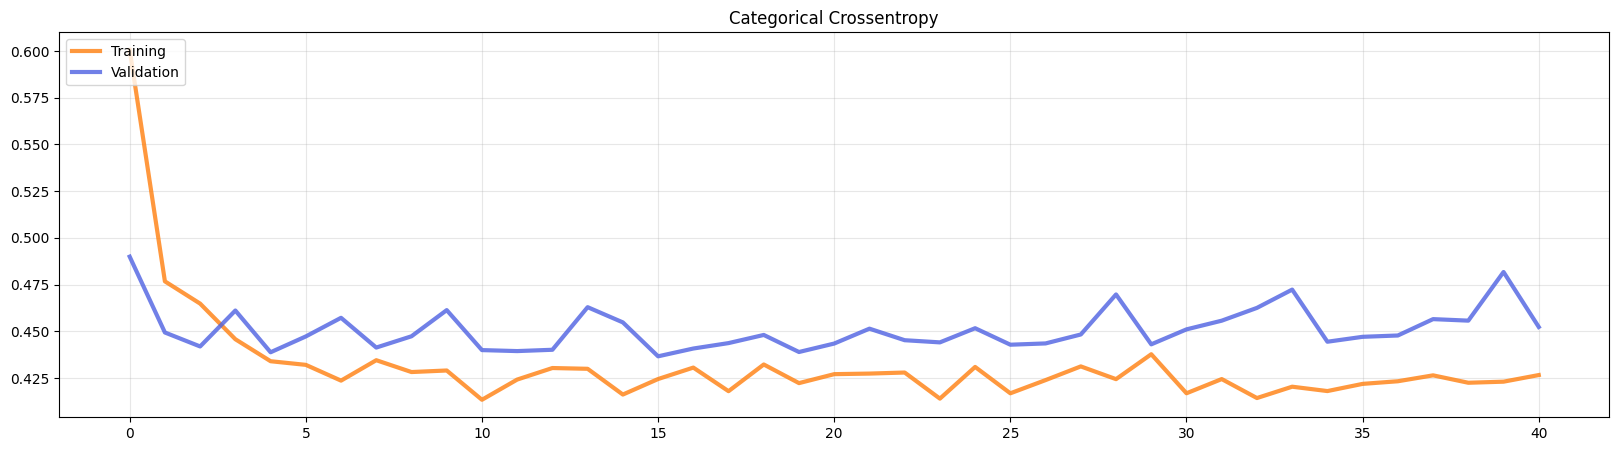

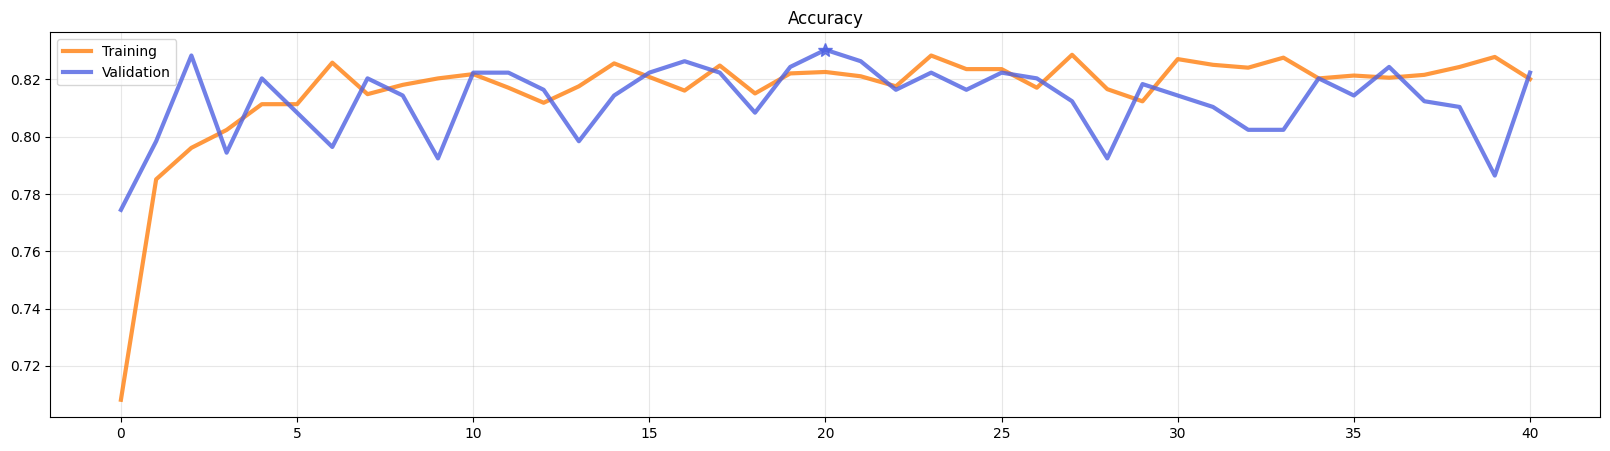

In [ ]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [ ]:
# Evaluate the model on the test set
test_accuracy = ft_model.evaluate(preprocess_input(X_test*255),y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

Test set accuracy 0.8064


In [ ]:
# Predict labels for the entire test set
predictions = ft_model.predict(preprocess_input(X_test*255), verbose=0)

#predictions now are probabilities !
#convert in 0 and 1
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)


Predictions Shape: (501, 1)


Accuracy: 0.8064
Precision: 0.803
Recall: 0.7792
F1: 0.7873


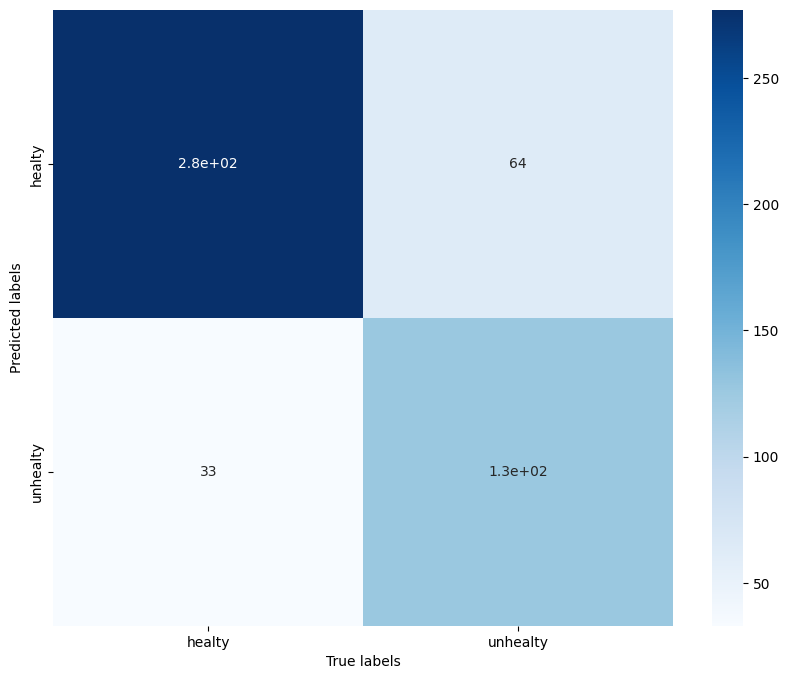

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_test,binary_predictions)

# Compute classification metrics
accuracy = accuracy_score(y_test, binary_predictions)
precision = precision_score(y_test, binary_predictions, average='macro')
recall = recall_score(y_test, binary_predictions, average='macro')
f1 = f1_score(y_test, binary_predictions, average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()